In [11]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Other utilities
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [12]:
# Load the dataset
df = pd.read_csv('electricity_theft_dataset.csv')

# Display basic info
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Basic statistics
print("\nDescriptive statistics:")
display(df.describe())

# Check class distribution
print("\nClass distribution (theft_detected):")
print(df['theft_detected'].value_counts(normalize=True))

Dataset shape: (100000, 14)

First 5 rows:


,customer_id,month,billed_consumption,actual_consumption,average_voltage,peak_usage_time,peak_time_consumption,off_peak_consumption,power_factor,payment_history,num_outages,customer_type,location,theft_detected
0,1001,2024-04,524,903.59,183.11,22:09,452.24,451.35,0.98,Good,2,Residential,urban,1
1,1002,2024-05,261,265.29,211.88,10:36,79.04,186.25,0.94,Good,0,Industrial,suburban,0
2,1003,2024-05,434,443.71,207.57,16:49,187.58,256.12,1.11,Good,3,Commercial,rural,0
3,1004,2024-09,546,889.49,228.48,19:46,374.34,515.15,0.89,Poor,1,Industrial,suburban,1
4,1005,2024-11,246,336.29,264.81,16:43,150.24,186.05,1.15,Poor,5,Commercial,suburban,1



Missing values per column:
customer_id              0
month                    0
billed_consumption       0
actual_consumption       0
average_voltage          0
peak_usage_time          0
peak_time_consumption    0
off_peak_consumption     0
power_factor             0
payment_history          0
num_outages              0
customer_type            0
location                 0
theft_detected           0
dtype: int64

Descriptive statistics:


,customer_id,billed_consumption,actual_consumption,average_voltage,peak_time_consumption,off_peak_consumption,power_factor,num_outages,theft_detected
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,51000.500000,374.94456,490.290328,220.219537,195.880607,294.409727,0.899846,2.506990,0.501900
std,28867.657797,129.90265,183.835252,25.533873,83.017190,117.035358,0.118991,1.706025,0.499999
min,1001.000000,150.00000,105.850000,173.640000,31.830000,52.430000,0.640000,0.000000,0.000000
25%,26000.750000,263.00000,356.760000,198.200000,134.700000,208.317500,0.810000,1.000000,0.000000
50%,51000.500000,375.00000,482.820000,220.380000,187.150000,286.750000,0.900000,3.000000,1.000000
75%,76000.250000,487.00000,615.292500,242.350000,247.530000,370.782500,0.990000,4.000000,1.000000
max,101000.000000,600.00000,1056.270000,267.550000,596.590000,768.290000,1.200000,5.000000,1.000000



Class distribution (theft_detected):
theft_detected
1    0.5019
0    0.4981
Name: proportion, dtype: float64


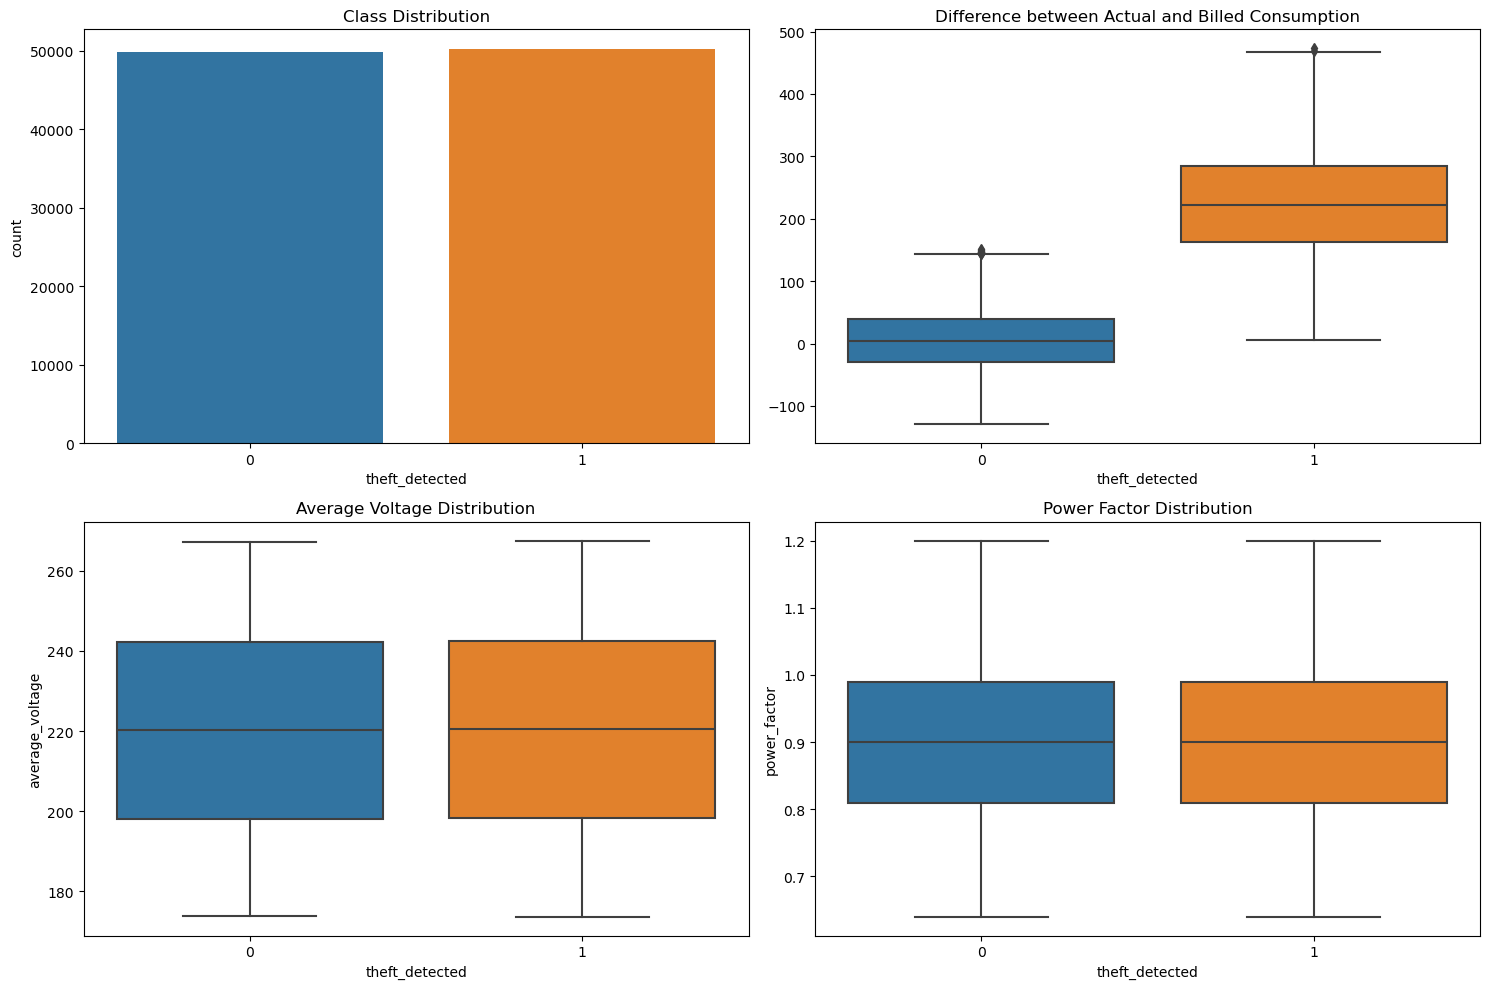

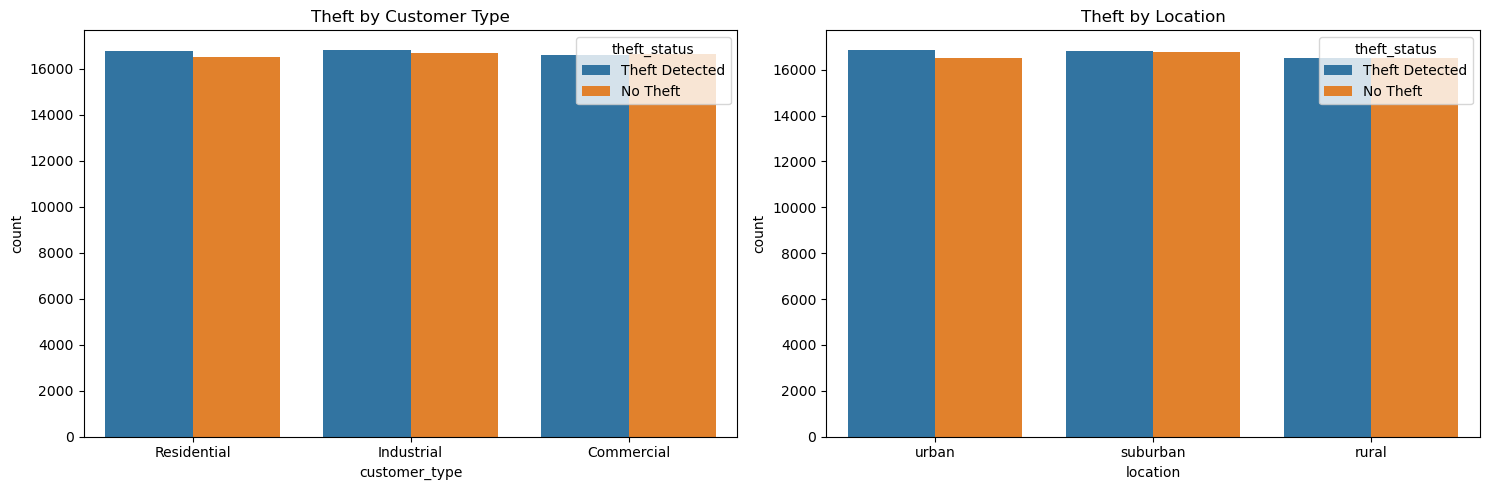

In [13]:
# Set up the figure
plt.figure(figsize=(15, 10))

# Plot 1: Class distribution
plt.subplot(2, 2, 1)
sns.countplot(x='theft_detected', data=df)
plt.title('Class Distribution')

# Plot 2: Consumption difference (actual - billed)
plt.subplot(2, 2, 2)
sns.boxplot(x='theft_detected', y=df['actual_consumption']-df['billed_consumption'], data=df)
plt.title('Difference between Actual and Billed Consumption')

# Plot 3: Average voltage by theft status
plt.subplot(2, 2, 3)
sns.boxplot(x='theft_detected', y='average_voltage', data=df)
plt.title('Average Voltage Distribution')

# Plot 4: Power factor by theft status
plt.subplot(2, 2, 4)
sns.boxplot(x='theft_detected', y='power_factor', data=df)
plt.title('Power Factor Distribution')

plt.tight_layout()
plt.show()

# Additional visualizations
plt.figure(figsize=(15, 5))

# Convert theft_detected to string for countplot
df['theft_status'] = df['theft_detected'].map({0: 'No Theft', 1: 'Theft Detected'})

# Customer type vs theft
plt.subplot(1, 2, 1)
sns.countplot(x='customer_type', hue='theft_status', data=df)
plt.title('Theft by Customer Type')

# Location vs theft
plt.subplot(1, 2, 2)
sns.countplot(x='location', hue='theft_status', data=df)
plt.title('Theft by Location')

plt.tight_layout()
plt.show()

# Remove the temporary column
df.drop('theft_status', axis=1, inplace=True)

In [14]:
# Create new features
df['consumption_diff'] = df['actual_consumption'] - df['billed_consumption']
df['consumption_ratio'] = df['actual_consumption'] / df['billed_consumption']
df['peak_offpeak_ratio'] = df['peak_time_consumption'] / df['off_peak_consumption']

# Extract hour from peak_usage_time
df['peak_hour'] = pd.to_datetime(df['peak_usage_time']).dt.hour

# Create time of day categories
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

df['time_of_day'] = df['peak_hour'].apply(get_time_of_day)

# Drop original time column
df.drop('peak_usage_time', axis=1, inplace=True)

# Display new features
print("New features created:")
display(df[['consumption_diff', 'consumption_ratio', 'peak_offpeak_ratio', 'peak_hour', 'time_of_day']].head())

New features created:


,consumption_diff,consumption_ratio,peak_offpeak_ratio,peak_hour,time_of_day
0,379.59,1.724408,1.001972,22,night
1,4.29,1.016437,0.424376,10,morning
2,9.71,1.022373,0.732391,16,afternoon
3,343.49,1.629103,0.726662,19,evening
4,90.29,1.367033,0.807525,16,afternoon


In [15]:
# Define features and target AFTER all feature engineering
X = df.drop(['customer_id', 'theft_detected'], axis=1)
y = df['theft_detected']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify column types
numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()

print("Numerical cols:", numerical_cols)
print("Categorical cols:", categorical_cols)

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Apply preprocessing
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

Numerical cols: ['billed_consumption', 'actual_consumption', 'average_voltage', 'peak_time_consumption', 'off_peak_consumption', 'power_factor', 'num_outages', 'consumption_diff', 'consumption_ratio', 'peak_offpeak_ratio', 'peak_hour']
Categorical cols: ['month', 'payment_history', 'customer_type', 'location', 'time_of_day']


In [16]:
# Define features and target
X = df.drop(['customer_id', 'theft_detected'], axis=1)
y = df['theft_detected']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify categorical and numerical columns
# First exclude any non-numeric columns that shouldn't be scaled
non_numeric_cols = ['month', 'customer_type', 'location', 'payment_history', 'time_of_day']
numerical_cols = [col for col in X.columns if col not in non_numeric_cols]

# For the month column, let's extract year and month as separate numerical features
def process_month(df):
    df = df.copy()
    df['month'] = pd.to_datetime(df['month'])
    df['year'] = df['month'].dt.year
    df['month_num'] = df['month'].dt.month
    df = df.drop('month', axis=1)
    return df

# Apply month processing
X_train = process_month(X_train)
X_test = process_month(X_test)

# Update numerical and categorical columns after processing
numerical_cols.extend(['year', 'month_num'])  # Add the new numerical features
categorical_cols = ['customer_type', 'location', 'payment_history', 'time_of_day']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Apply preprocessing
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Get feature names after one-hot encoding
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_cols)
feature_names = np.concatenate([numerical_cols, cat_feature_names])

print("Preprocessing completed. Feature names:")
print(feature_names)

Preprocessing completed. Feature names:
['billed_consumption' 'actual_consumption' 'average_voltage'
 'peak_time_consumption' 'off_peak_consumption' 'power_factor'
 'num_outages' 'consumption_diff' 'consumption_ratio' 'peak_offpeak_ratio'
 'peak_hour' 'year' 'month_num' 'customer_type_Commercial'
 'customer_type_Industrial' 'customer_type_Residential' 'location_rural'
 'location_suburban' 'location_urban' 'payment_history_Good'
 'payment_history_Poor' 'time_of_day_afternoon' 'time_of_day_evening'
 'time_of_day_morning' 'time_of_day_night']



Logistic Regression Performance
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      9962
           1       0.97      0.96      0.97     10038

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000


Random Forest Performance
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      9962
           1       0.98      0.96      0.97     10038

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000


XGBoost Performance
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      9962
           1       0.97      0.96      0.97     10038

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97    

,Model,Accuracy,Precision,Recall,F1,ROC AUC,Classifier
3,LightGBM,0.966900,0.973058,0.960650,0.966814,0.996674,LGBMClassifier(random_state=42)
1,Random Forest,0.967650,0.975109,0.960052,0.967522,0.996598,RandomForestClassifier(random_state=42)
2,XGBoost,0.966250,0.972259,0.960151,0.966167,0.996198,"XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric='logloss', feature_types=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=None, num_parallel_tree=None, random_state=42, ...)"
0,Logistic Regression,0.965850,0.969581,0.962144,0.965848,0.996145,"LogisticRegression(max_iter=1000, random_state=42)"




Confusion Matrices:


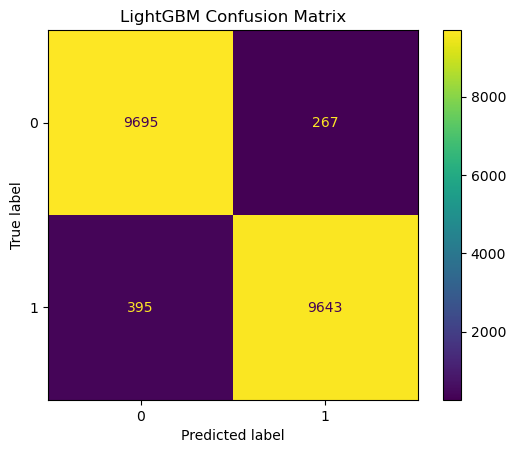

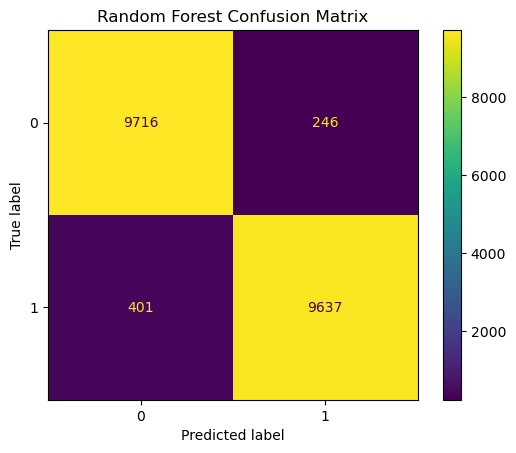

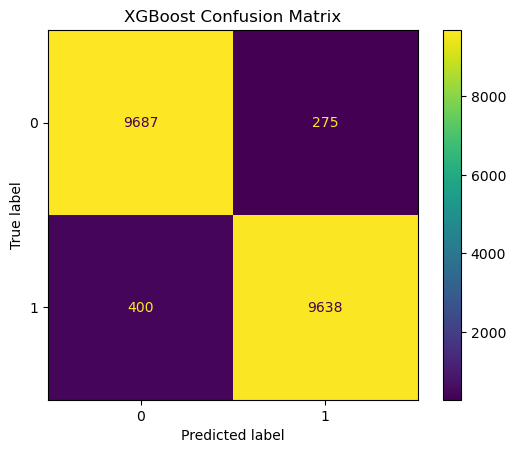

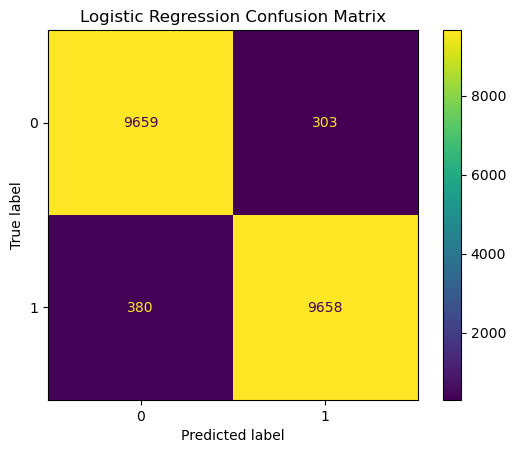

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(random_state=42)
}

# Store results using list instead of DataFrame.append()
metrics_data = []

for name, model in models.items():
    # Train model
    model.fit(X_train_preprocessed, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_preprocessed)
    y_proba = model.predict_proba(X_test_preprocessed)[:, 1]
    
    # Calculate metrics
    metrics_data.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba),
        'Classifier': model  # Store model reference for confusion matrix
    })
    
    # Display detailed report
    print(f"\n{'='*40}\n{name} Performance\n{'='*40}")
    print(classification_report(y_test, y_pred))

# Create DataFrame from list
metrics_df = pd.DataFrame(metrics_data)

# Display comparative metrics
print("\n\nComparative Model Performance:")
metrics_df = metrics_df.sort_values('ROC AUC', ascending=False)
styled_df = metrics_df.style.background_gradient(
    cmap='Blues', 
    subset=['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC']
)
display(styled_df)

# Plot confusion matrices separately
print("\n\nConfusion Matrices:")
for _, row in metrics_df.iterrows():
    ConfusionMatrixDisplay.from_estimator(
        row['Classifier'], 
        X_test_preprocessed, 
        y_test
    )
    plt.title(f"{row['Model']} Confusion Matrix")
    plt.show()

In [20]:
# Example for Random Forest tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train_preprocessed, y_train)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best ROC AUC score:", grid_search.best_score_)

# Evaluate on test set
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test_preprocessed)
y_prob = best_rf.predict_proba(X_test_preprocessed)[:, 1]

print("\nTuned Random Forest Performance:")
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best ROC AUC score: 0.9966207167600787

Tuned Random Forest Performance:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      9962
           1       0.98      0.96      0.97     10038

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000

ROC AUC: 0.9968522645467002


In [24]:
%%time

# First ensure we process the month column in the full dataset X
# (same processing we did for X_train/X_test)
def process_month(df):
    df = df.copy()
    df['month'] = pd.to_datetime(df['month'])
    df['year'] = df['month'].dt.year
    df['month_num'] = df['month'].dt.month
    df = df.drop('month', axis=1)
    return df

# Process the month column in X (full dataset)
X_processed = process_month(X)

# Update numerical and categorical columns (same as before)
numerical_cols = [col for col in X_processed.columns 
                 if col not in ['customer_type', 'location', 'payment_history', 'time_of_day']]
numerical_cols.extend(['year', 'month_num'])  # Add the new numerical features
categorical_cols = ['customer_type', 'location', 'payment_history', 'time_of_day']

# Recreate the preprocessor with correct columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Train final model on all data with best parameters
final_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

# Create full pipeline including preprocessing
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', final_model)
])

# Fit on all data (using processed X and original y)
full_pipeline.fit(X_processed, y)

# Function to make predictions on new data
def predict_theft(new_data):
    """
    Predict electricity theft for new data.
    
    Parameters:
    new_data (DataFrame): New data with same features as training data
    
    Returns:
    array: Predicted classes (0: no theft, 1: theft)
    array: Probability estimates for class 1
    """
    # Process the month column in new data
    new_data_processed = process_month(new_data)
    
    # Verify all required columns are present
    required_cols = numerical_cols + categorical_cols
    missing_cols = set(required_cols) - set(new_data_processed.columns)
    if missing_cols:
        raise ValueError(f"Missing columns in input data: {missing_cols}")
    
    predictions = full_pipeline.predict(new_data_processed)
    probabilities = full_pipeline.predict_proba(new_data_processed)[:, 1]
    return predictions, probabilities

# Example usage (with proper column checking)
try:
    example_data = X.sample(5)
    preds, probs = predict_theft(example_data)
    print("Example predictions:")
    print(pd.DataFrame({
        'Prediction': preds,
        'Probability': probs
    }))
except Exception as e:
    print(f"Error in example prediction: {str(e)}")

Example predictions:
   Prediction  Probability
0           0     0.087443
1           0     0.000000
2           0     0.000000
3           0     0.000000
4           0     0.000116
CPU times: total: 1min 1s
Wall time: 1min 6s


In [25]:
import joblib

# Save the pipeline
joblib.dump(full_pipeline, 'electricity_theft_model.pkl')

# To load the model later:
# loaded_model = joblib.load('electricity_theft_model.pkl')

['electricity_theft_model.pkl']